# Data Analysis with Pandas

| Information | Details |
|----------|---------|
| Learning Objectives | • Load and explore power system datasets<br>• Master DataFrame indexing and selection<br>• Clean operational data for analysis<br>• Perform time-series operations<br>• Aggregate data by categories<br>• Avoid common Pandas pitfalls |
| Prerequisites | Basic Python, NumPy arrays, power system concepts |
| Estimated Time | 60 minutes |
| Topics | DataFrames, indexing (loc/iloc), time series, data cleaning, aggregation |

## Introduction

Power systems generate vast amounts of time-series data from SCADA systems, energy markets, weather stations, and smart meters. This lesson introduces Pandas, Python's primary data manipulation library, through practical power system applications. You'll learn to handle the structured, time-indexed data that characterizes power system operations.

Pandas excels at the data manipulation tasks you'll encounter daily in power systems analysis. Whether you're calculating system reliability metrics, processing market settlements, or analyzing generator performance, Pandas provides the essential tools for efficient data analysis. We'll focus on the fundamental operations you need most, building your skills progressively through realistic examples while highlighting common pitfalls that can trip up even experienced users.

## Setting Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 2)

print(f"Pandas version: {pd.__version__}")

Pandas version: 2.2.3


## Creating Sample Power System Data

To learn Pandas effectively, we need realistic power system data. Let's create datasets representing common data types you'll encounter: generation output from different units, system load measurements, and market prices. These datasets will exhibit typical patterns like daily load cycles and the relationship between demand and price.

In [2]:
# Create 24 hours of 5-minute data
np.random.seed(42)
timestamps = pd.date_range('2024-01-01', periods=288, freq='5min')

# Base generation values for different units
coal_base = 350  # MW
gas_base = 150   # MW
wind_base = 50   # MW
solar_max = 60   # MW peak

In [3]:
# Generate realistic patterns
generation_data = pd.DataFrame({
    'timestamp': timestamps,
    'coal': coal_base + np.random.normal(0, 5, 288),
    'gas': gas_base + 50 * np.sin(np.linspace(0, 4*np.pi, 288)),
    'wind': np.maximum(0, wind_base + np.random.normal(0, 20, 288)),
    'solar': solar_max * np.maximum(0, np.sin(np.linspace(0, np.pi, 288)))**2
})

print("Sample generation data:")
print(generation_data.head())
print(f"\nDataFrame shape: {generation_data.shape}")

Sample generation data:
            timestamp    coal     gas   wind     solar
0 2024-01-01 00:00:00  352.48  150.00  55.62  0.00e+00
1 2024-01-01 00:05:00  349.31  152.19  37.55  7.19e-03
2 2024-01-01 00:10:00  353.24  154.37  45.84  2.88e-02
3 2024-01-01 00:15:00  357.62  156.55  40.14  6.47e-02
4 2024-01-01 00:20:00  348.83  158.71  38.21  1.15e-01

DataFrame shape: (288, 5)


The generation data shows typical patterns for each technology. Coal provides steady baseload power with minimal variation. Gas units follow load, ramping up and down throughout the day. Wind varies randomly, reflecting the intermittent nature of wind resources. Solar follows a predictable daily pattern, peaking at midday.

Now let's create corresponding load and price data to complete our dataset:

In [4]:
# Create load data with daily pattern
base_load = 600  # MW
daily_pattern = 100 * np.sin(np.linspace(-np.pi/2, 3*np.pi/2, 288))
load = base_load + daily_pattern + np.random.normal(0, 10, 288)

load_data = pd.DataFrame({
    'timestamp': timestamps,
    'system_load': load
})

In [5]:
# Create price data correlated with load
base_price = 30  # $/MWh
load_factor = (load - load.min()) / (load.max() - load.min())
prices = base_price + 20 * load_factor + np.random.normal(0, 2, 288)

price_data = pd.DataFrame({
    'timestamp': timestamps,
    'lmp': prices
})

print(f"Load range: {load.min():.0f} - {load.max():.0f} MW")
print(f"Price range: ${prices.min():.2f} - ${prices.max():.2f}/MWh")

Load range: 485 - 714 MW
Price range: $28.31 - $53.01/MWh


## Working with DataFrames

DataFrames are the core data structure in Pandas, perfect for the tabular data common in power systems. Each column represents a different measurement or variable, while rows represent observations at different times. Let's explore how to load, examine, and manipulate this data.

```{admonition} Key Concept: DataFrame Structure
:class: note
A DataFrame is like a spreadsheet in memory. Rows have an **index** (labels for each row), and columns have **names**. Understanding this dual-labeling system is crucial for effective data manipulation.
```

In [6]:
# Save and reload data (simulating real file operations)
generation_data.to_csv('generation.csv', index=False)
gen_df = pd.read_csv('generation.csv', parse_dates=['timestamp'])

print("DataFrame shape:", gen_df.shape)
print("\nData types:")
print(gen_df.dtypes)

DataFrame shape: (288, 5)

Data types:
timestamp    datetime64[ns]
coal                float64
gas                 float64
wind                float64
solar               float64
dtype: object


Notice that Pandas automatically recognized the timestamp column as a datetime when we used `parse_dates`. This is crucial for time-series operations. The shape tells us we have 288 time periods (5-minute intervals over 24 hours) and 5 columns.

Let's explore the data more thoroughly using Pandas' built-in methods:

In [7]:
# Basic exploration
print("Statistical summary:")
print(gen_df.describe())

print("\nTime range:")
print(f"Start: {gen_df['timestamp'].min()}")
print(f"End: {gen_df['timestamp'].max()}")

Statistical summary:
                 timestamp    coal     gas    wind   solar
count                  288  288.00  288.00  288.00  288.00
mean   2024-01-01 11:57:30  349.94  150.00   49.51   29.90
min    2024-01-01 00:00:00  333.79  100.00    0.57    0.00
25%    2024-01-01 05:58:45  346.45  114.84   36.11    8.73
50%    2024-01-01 11:57:30  350.26  150.00   49.60   29.84
75%    2024-01-01 17:56:15  353.08  185.16   62.46   51.04
max    2024-01-01 23:55:00  369.26  200.00  111.58   60.00
std                    NaN    4.98   35.36   19.22   21.29

Time range:
Start: 2024-01-01 00:00:00
End: 2024-01-01 23:55:00


## Setting the Index

For time-series data, setting the timestamp as the index enables powerful time-based operations. This is a fundamental step that transforms how you can work with the data, allowing for easy time-based selection, resampling, and alignment of different datasets.

```{admonition} Warning: Index Changes Access Patterns
:class: warning
After setting a datetime index, you can no longer use integer positions directly with square brackets. Use `.iloc[0]` for position-based access or `.loc['2024-01-01']` for label-based access.
```

### Before setting index

In [8]:
print("Before setting index:")
print(gen_df.head(3))
print(f"\nAccessing row 0: gen_df.iloc[0]['coal'] = {gen_df.iloc[0]['coal']:.2f}")

Before setting index:
            timestamp    coal     gas   wind     solar
0 2024-01-01 00:00:00  352.48  150.00  55.62  0.00e+00
1 2024-01-01 00:05:00  349.31  152.19  37.55  7.19e-03
2 2024-01-01 00:10:00  353.24  154.37  45.84  2.88e-02

Accessing row 0: gen_df.iloc[0]['coal'] = 352.48


### After setting timestamp as index

In [9]:
# Set timestamp as index
gen_df = gen_df.set_index('timestamp')
load_df = load_data.set_index('timestamp')
price_df = price_data.set_index('timestamp')

print("After setting timestamp index:")
print(gen_df.head(3))

After setting timestamp index:
                       coal     gas   wind     solar
timestamp                                           
2024-01-01 00:00:00  352.48  150.00  55.62  0.00e+00
2024-01-01 00:05:00  349.31  152.19  37.55  7.19e-03
2024-01-01 00:10:00  353.24  154.37  45.84  2.88e-02


### Access patterns after setting index

- **WRONG:** `gen_df[0]` - This raises KeyError!
- **RIGHT:** `gen_df.iloc[0]` - Access by position
- **RIGHT:** `gen_df.loc['2024-01-01 00:00:00']` - Access by label

In [10]:
# Demonstrate correct access patterns
print("Access by position (iloc):")
print(gen_df.iloc[0])  # First row
print()
print("Access by label (loc):")
print(gen_df.loc['2024-01-01 00:00:00'])  # Specific timestamp

Access by position (iloc):
coal     352.48
gas      150.00
wind      55.62
solar      0.00
Name: 2024-01-01 00:00:00, dtype: float64

Access by label (loc):
coal     352.48
gas      150.00
wind      55.62
solar      0.00
Name: 2024-01-01 00:00:00, dtype: float64


## DataFrame Indexing and Selection

Understanding how to select data from DataFrames is crucial but often confusing for beginners. Pandas provides multiple ways to access data, each with specific use cases. Let's explore the main methods and their differences.

```{admonition} Key Indexing Methods
:class: info
- **`.loc[]`** - Label-based selection (use index/column names)
- **`.iloc[]`** - Integer position-based selection (like array indexing)
- **`.at[]`** - Fast scalar label-based access
- **`.iat[]`** - Fast scalar position-based access
- **`[]`** - Column selection or boolean filtering
```

### Column Selection - The Simplest Method

#### Single column (returns Series):

In [11]:
gen_df['coal'].head(3)

timestamp
2024-01-01 00:00:00    352.48
2024-01-01 00:05:00    349.31
2024-01-01 00:10:00    353.24
Name: coal, dtype: float64

#### Multiple columns (returns DataFrame):

In [12]:
gen_df[['coal', 'gas']].head(3)

,coal,gas
timestamp,,
2024-01-01 00:00:00,352.48,150.00
2024-01-01 00:05:00,349.31,152.19
2024-01-01 00:10:00,353.24,154.37


### loc (label-based) vs iloc (position-based)

#### Using loc with timestamp label:

In [13]:
gen_df.loc['2024-01-01 01:00:00', 'coal']  # Specific cell

np.float64(351.2098113578302)

#### Using iloc with integer positions:

In [14]:
gen_df.iloc[12, 0]  # Row 12 (13th row), column 0 (coal)

np.float64(351.2098113578302)

#### Slicing with loc (inclusive of end):

In [15]:
gen_df.loc['2024-01-01 00:00:00':'2024-01-01 00:10:00', 'coal']

timestamp
2024-01-01 00:00:00    352.48
2024-01-01 00:05:00    349.31
2024-01-01 00:10:00    353.24
Name: coal, dtype: float64

#### Slicing with iloc (exclusive of end):

In [16]:
gen_df.iloc[0:3, 0]  # First 3 rows, first column

timestamp
2024-01-01 00:00:00    352.48
2024-01-01 00:05:00    349.31
2024-01-01 00:10:00    353.24
Name: coal, dtype: float64

### at and iat for Fast Scalar Access

#### Using at (label-based):

In [17]:
print(f"Coal at 2024-01-01 00:00:00: {gen_df.at['2024-01-01 00:00:00', 'coal']:.2f}")

Coal at 2024-01-01 00:00:00: 352.48


#### Using iat (position-based):

In [18]:
print(f"Value at position [0, 0]: {gen_df.iat[0, 0]:.2f}")

Value at position [0, 0]: 352.48


```{admonition} Common Pitfall: Boolean Indexing
:class: warning
When filtering data with conditions, always use `.loc[]` for setting values to avoid the SettingWithCopyWarning. Never chain operations when modifying data.
```

### Boolean Indexing - RIGHT and WRONG Ways

- **WRONG - Chained assignment:**
```python
demo_df[demo_df['coal'] > 360]['coal'] = 360  # Don't do this!
```

- **RIGHT - Using loc with boolean mask:**

In [19]:
# Create a copy for demonstration
demo_df = gen_df.copy()

# RIGHT way - using loc with boolean mask
mask = demo_df['coal'] > 360
demo_df.loc[mask, 'coal'] = 360
print(f"Capped {mask.sum()} values above 360 MW")
print(f"New max coal: {demo_df['coal'].max():.2f} MW")

Capped 8 values above 360 MW
New max coal: 360.00 MW


### Time-based Selection

In [20]:
morning_gen = gen_df.between_time('06:00', '12:00')
print(f"Morning generation averages:")
print(morning_gen.mean())

Morning generation averages:
coal     349.74
gas      118.73
wind      52.68
solar     49.18
dtype: float64


#### Partial string indexing (very convenient for time series):

In [21]:
gen_df.loc['2024-01-01 06:00':'2024-01-01 06:30', 'solar']

timestamp
2024-01-01 06:00:00    30.16
2024-01-01 06:05:00    30.82
2024-01-01 06:10:00    31.48
2024-01-01 06:15:00    32.13
2024-01-01 06:20:00    32.79
2024-01-01 06:25:00    33.44
2024-01-01 06:30:00    34.09
Name: solar, dtype: float64

## Data Cleaning

Real power system data often contains quality issues from communication failures, sensor errors, or data collection problems. Common issues include missing values from SCADA dropouts and unrealistic measurements from faulty sensors. Let's learn how to identify and handle these problems.

```{admonition} Best Practice: Always Copy When Cleaning
:class: tip
When cleaning data, work on a copy (`df.copy()`) to preserve the original. This prevents accidental data loss and allows you to compare before/after.
```

In [22]:
# Create data with quality issues
messy_data = gen_df.copy()  # Always work on a copy!

# Introduce missing values (SCADA dropout)
dropout_times = np.random.choice(messy_data.index[50:100], size=5)
messy_data.loc[dropout_times, 'wind'] = np.nan

# Introduce unrealistic value
messy_data.iloc[150, 2] = -50  # Negative wind generation

print(f"Missing values by column:")
print(messy_data.isnull().sum())
print(f"\nNegative wind values: {(messy_data['wind'] < 0).sum()}")

Missing values by column:
coal     0
gas      0
wind     4
solar    0
dtype: int64

Negative wind values: 1


Missing values and unrealistic measurements can corrupt your analysis if not handled properly. For time-series data, interpolation often provides a reasonable estimate for short gaps. For unrealistic values, domain knowledge helps identify and correct problems.

```{admonition} Warning: SettingWithCopyWarning
:class: warning
If you see `SettingWithCopyWarning`, it means you're trying to modify a view of the data rather than the data itself. This often happens with chained operations. Always use `.copy()` when creating subsets you plan to modify.
```

### SettingWithCopyWarning Demonstration

- **WRONG - Creating a view (can cause warnings):**

In [23]:
subset_wrong = messy_data[messy_data['coal'] > 350]
print(f"Is this a view? {subset_wrong._is_view}")
# subset_wrong['coal'] = 350  # This would trigger SettingWithCopyWarning!

Is this a view? False


- **RIGHT - Creating a copy:**

In [24]:
subset_right = messy_data[messy_data['coal'] > 350].copy()
subset_right['coal'] = 350  # This is safe
print(f"Modified {len(subset_right)} rows safely")

Modified 148 rows safely


### Clean the Data Properly

In [25]:
clean_data = messy_data.copy()

# Fix negative values
negative_mask = clean_data['wind'] < 0
clean_data.loc[negative_mask, 'wind'] = 0  # Use loc for safe assignment

# Interpolate missing values (linear for small gaps)
clean_data['wind'] = clean_data['wind'].interpolate(method='linear', limit=3)

print(f"Remaining missing values: {clean_data.isnull().sum().sum()}")
print(f"Wind generation range: {clean_data['wind'].min():.1f} - {clean_data['wind'].max():.1f} MW")

Remaining missing values: 0
Wind generation range: 0.0 - 111.6 MW


## Time Series Operations

Power system data is inherently temporal, and you'll frequently need to change time resolutions or calculate rolling statistics. Resampling converts data between different time frequencies, while rolling calculations help identify trends and smooth noisy measurements.

```{admonition} Performance Tip: Vectorization
:class: tip
Pandas operations are optimized for entire columns. Avoid iterating over rows with `iterrows()` unless absolutely necessary. Vectorized operations can be 100x faster.
```

### Vectorization vs Iteration Performance

In [26]:
import time

# SLOW - Iterating over rows
start = time.time()
total_slow = 0
for idx, row in gen_df.iterrows():
    total_slow += row['coal'] + row['gas']
time_slow = time.time() - start

# FAST - Vectorized operation
start = time.time()
total_fast = (gen_df['coal'] + gen_df['gas']).sum()
time_fast = time.time() - start

print(f"Iteration time: {time_slow*1000:.2f} ms")
print(f"Vectorized time: {time_fast*1000:.2f} ms")
print(f"Speedup: {time_slow/time_fast:.1f}x faster")

Iteration time: 6.25 ms
Vectorized time: 1.17 ms
Speedup: 5.4x faster


### Resampling Data

In [27]:
# Resample to hourly (average for power, sum for energy)
gen_hourly = gen_df.resample('1h').mean()  # Use lowercase 'h' in newer pandas
energy_hourly = gen_df.resample('1h').sum() / 12  # Convert to MWh

print(f"Original: {len(gen_df)} five-minute periods")
print(f"Resampled: {len(gen_hourly)} hourly periods")
print("\nHourly averages (MW):")
print(gen_hourly.head(3))
print(f"\nMemory usage comparison:")
print(f"Original: {gen_df.memory_usage().sum() / 1024:.1f} KB")
print(f"Hourly: {gen_hourly.memory_usage().sum() / 1024:.1f} KB")

Original: 288 five-minute periods
Resampled: 24 hourly periods

Hourly averages (MW):
                       coal     gas   wind  solar
timestamp                                        
2024-01-01 00:00:00  351.48  161.79  52.55   0.30
2024-01-01 01:00:00  347.04  184.28  53.30   2.25
2024-01-01 02:00:00  349.03  197.52  59.16   6.11

Memory usage comparison:
Original: 19.4 KB
Hourly: 0.9 KB


### Rolling Calculations

In [28]:
# Calculate 30-minute rolling average
gen_df['coal_smooth'] = gen_df['coal'].rolling(window=6).mean()

# Note about the first few values
print("First few values of rolling average:")
print(gen_df[['coal', 'coal_smooth']].head(8))
print("\nNotice: First 5 values are NaN (window=6)")

First few values of rolling average:
                       coal  coal_smooth
timestamp                               
2024-01-01 00:00:00  352.48          NaN
2024-01-01 00:05:00  349.31          NaN
2024-01-01 00:10:00  353.24          NaN
2024-01-01 00:15:00  357.62          NaN
2024-01-01 00:20:00  348.83          NaN
2024-01-01 00:25:00  348.83       351.72
2024-01-01 00:30:00  357.90       352.62
2024-01-01 00:35:00  353.84       353.37

Notice: First 5 values are NaN (window=6)


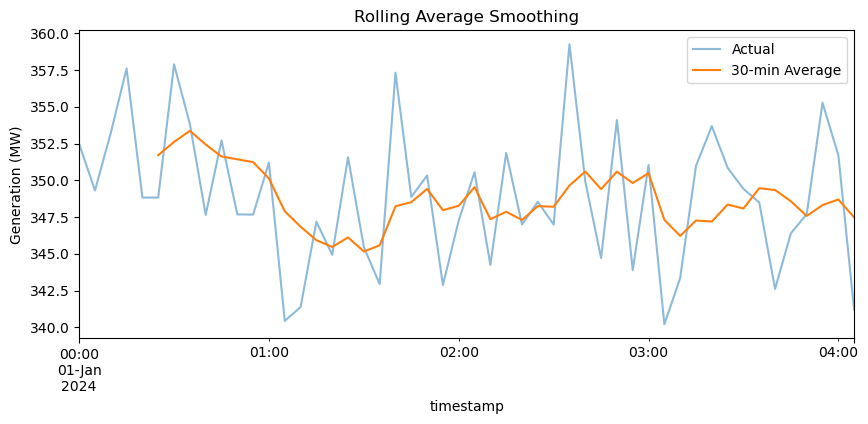

In [29]:
# Plot to visualize
plt.figure(figsize=(10, 4))
gen_df['coal'][:50].plot(label='Actual', alpha=0.5)
gen_df['coal_smooth'][:50].plot(label='30-min Average')
plt.ylabel('Generation (MW)')
plt.title('Rolling Average Smoothing')
plt.legend()
plt.show()

The rolling average smooths out short-term fluctuations, revealing the underlying trend. This technique is valuable for identifying patterns in noisy data and calculating metrics like moving average prices or rolling standard deviations for volatility analysis.

```{admonition} Note: Rolling Window Edge Effects
:class: note
Rolling operations produce NaN values for the first (window-1) periods by default. Use `min_periods` parameter if you need values for these initial periods.
```

## Aggregation and Grouping

Analyzing data by categories reveals important patterns in power system operations. You might need to compare generation by fuel type, analyze load patterns by hour of day, or calculate statistics by different time periods. The groupby operation is fundamental to these analyses.

```{admonition} Memory Tip: GroupBy Objects
:class: tip
GroupBy operations don't immediately compute results - they create a GroupBy object that computes results lazily. This saves memory when working with large datasets.
```

In [30]:
# Add hour column for grouping
gen_df['hour'] = gen_df.index.hour

# Create GroupBy object (no computation yet)
grouped = gen_df.groupby('hour')
print(f"GroupBy object: {grouped}")
print(f"Number of groups: {grouped.ngroups}")

# Now compute specific aggregations
hourly_avg = grouped[['coal', 'gas', 'wind', 'solar']].mean()

print("\nAverage generation by hour (first 6 hours):")
print(hourly_avg.head(6))

GroupBy object: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7ff7b612e890>
Number of groups: 24

Average generation by hour (first 6 hours):
        coal     gas   wind  solar
hour                              
0     351.48  161.79  52.55   0.30
1     347.04  184.28  53.30   2.25
2     349.03  197.52  59.16   6.11
3     348.34  197.94  50.50  11.61
4     350.24  185.43  41.28  18.36
5     350.73  163.36  49.53  25.92


### Multiple Aggregations

In [31]:
agg_stats = gen_df.groupby('hour')['wind'].agg(['mean', 'std', 'min', 'max'])
print("Wind statistics by hour:")
print(agg_stats.head())

Wind statistics by hour:
       mean    std    min    max
hour                            
0     52.55  12.35  36.14  67.99
1     53.30  13.75  33.42  75.55
2     59.16  15.52  33.64  91.85
3     50.50  16.48  25.72  73.16
4     41.28  12.65  21.04  58.26


<Figure size 1000x400 with 0 Axes>

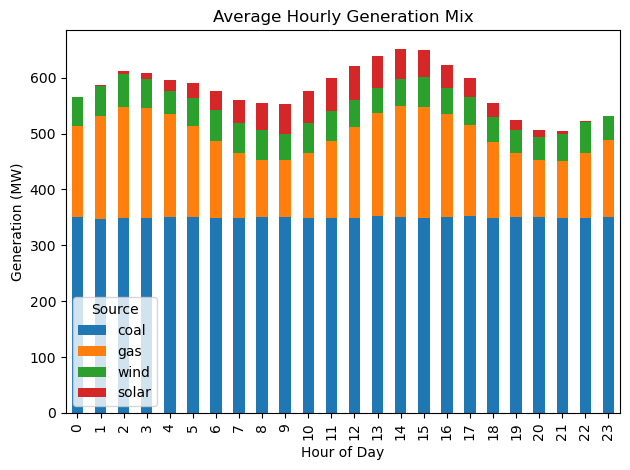

In [32]:
# Visualize hourly patterns
plt.figure(figsize=(10, 4))
hourly_avg.plot(kind='bar', stacked=True)
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MW)')
plt.title('Average Hourly Generation Mix')
plt.legend(title='Source')
plt.tight_layout()
plt.show()

The stacked bar chart clearly shows how the generation mix changes throughout the day. Solar peaks at midday, gas ramps up during high-demand periods, and coal provides steady baseload. This type of analysis helps operators understand system patterns and plan resources.

## Merging Datasets

Power system analysis often requires combining data from multiple sources. You might need to merge generation data with prices to calculate revenues, or combine load data with weather to analyze correlations. Pandas provides several merge operations for different scenarios.

```{admonition} Warning: Merge Key Duplicates
:class: warning
If your merge keys have duplicates, the result will contain all combinations (Cartesian product), potentially exploding memory usage. Always check for duplicates with `df.index.duplicated().sum()` before merging.
```

### Checking for Duplicate Indices

In [33]:
print(f"Generation duplicates: {gen_df.index.duplicated().sum()}")
print(f"Load duplicates: {load_df.index.duplicated().sum()}")
print(f"Price duplicates: {price_df.index.duplicated().sum()}")
print("\nSafe to merge!")

Generation duplicates: 0
Load duplicates: 0
Price duplicates: 0

Safe to merge!


### Merge Types Comparison

In [34]:
# Inner join (default) - only matching indices
inner_merge = gen_df.merge(load_df, left_index=True, right_index=True, how='inner')
print(f"Inner merge shape: {inner_merge.shape}")

# Left join - all from left, matching from right
left_merge = gen_df.merge(load_df, left_index=True, right_index=True, how='left')
print(f"Left merge shape: {left_merge.shape}")

# Check memory usage
print(f"\nMemory usage after merge: {inner_merge.memory_usage().sum() / 1024:.1f} KB")

Inner merge shape: (288, 7)
Left merge shape: (288, 7)

Memory usage after merge: 25.0 KB


### Merge All Datasets

In [35]:
# Merge all datasets
system_data = gen_df.merge(load_df, left_index=True, right_index=True)
system_data = system_data.merge(price_df, left_index=True, right_index=True)

# Calculate total generation
system_data['total_gen'] = system_data[['coal', 'gas', 'wind', 'solar']].sum(axis=1)

print("Merged system data:")
print(system_data[['total_gen', 'system_load', 'lmp']].head())
print(f"\nFinal shape: {system_data.shape}")

Merged system data:
                     total_gen  system_load    lmp
timestamp                                         
2024-01-01 00:00:00     558.10       502.36  30.29
2024-01-01 00:05:00     539.05       507.73  31.21
2024-01-01 00:10:00     553.48       485.31  30.60
2024-01-01 00:15:00     554.37       511.65  33.00
2024-01-01 00:20:00     545.87       503.77  32.96

Final shape: (288, 9)


In [36]:
# Analyze relationships
correlation = system_data[['system_load', 'lmp', 'total_gen']].corr()
print("Correlation matrix:")
print(correlation)

# Calculate generator revenues
system_data['coal_revenue'] = system_data['coal'] * system_data['lmp'] / 12
print(f"\nTotal coal revenue: ${system_data['coal_revenue'].sum():,.2f}")

Correlation matrix:
             system_load   lmp  total_gen
system_load         1.00  0.95       0.46
lmp                 0.95  1.00       0.44
total_gen           0.46  0.44       1.00

Total coal revenue: $338,804.42


The merged dataset enables comprehensive analysis. We can see the correlation between load and price, calculate revenues for each generator, and analyze the supply-demand balance. This integrated view is essential for market analysis and system planning.

## Common Pitfalls and Solutions

Let's address the most common issues that trip up Pandas users, especially when working with power system data.

### 1. View vs Copy Problem

```{admonition} Critical Concept: Views vs Copies
:class: important
Some Pandas operations return a **view** (reference to original data) while others return a **copy** (independent data). Modifying a view can unexpectedly change the original data or fail silently.
```

In [37]:
original = gen_df[['coal', 'gas']].copy()

# This might be a view or copy (unpredictable!)
subset_unclear = original[original['coal'] > 350]

# This is definitely a copy
subset_copy = original[original['coal'] > 350].copy()

# This is definitely a view
subset_view = original.loc[original['coal'] > 350]

print(f"Original shape: {original.shape}")
print(f"Subset shape: {subset_copy.shape}")
print("\nAlways use .copy() when you need independent data!")

Original shape: (288, 2)
Subset shape: (148, 2)

Always use .copy() when you need independent data!


### 2. Chained Assignment Problem

- **WRONG way (chained):**
```python
test_df[test_df['coal'] > 360]['coal'] = 360
# This may not work and triggers SettingWithCopyWarning!
```

- **RIGHT way (using loc):**

In [38]:
test_df = gen_df.copy()
mask = test_df['coal'] > 360
test_df.loc[mask, 'coal'] = 360
print(f"Successfully capped {mask.sum()} values")

Successfully capped 8 values


### 3. Memory Optimization

In [39]:
print("Original memory usage:")
print(gen_df.memory_usage(deep=True))

# Optimize data types
optimized = gen_df.copy()
optimized['hour'] = optimized['hour'].astype('int8')  # Hours only need 0-23

print("\nOptimized memory usage:")
print(optimized.memory_usage(deep=True))
print("\nMemory saved by using int8 for hour column!")

Original memory usage:
Index          10600
coal            2304
gas             2304
wind            2304
solar           2304
coal_smooth     2304
hour            1152
dtype: int64

Optimized memory usage:
Index          10600
coal            2304
gas             2304
wind            2304
solar           2304
coal_smooth     2304
hour             288
dtype: int64

Memory saved by using int8 for hour column!


### 4. Timezone Handling

In [40]:
print(f"Current timezone: {gen_df.index.tz}")
print("(None means timezone-naive)\n")

# Make timezone-aware
gen_tz = gen_df.copy()
gen_tz.index = gen_tz.index.tz_localize('US/Eastern')
print(f"After localization: {gen_tz.index.tz}")

# Convert to different timezone
gen_utc = gen_tz.copy()
gen_utc.index = gen_utc.index.tz_convert('UTC')
print(f"After conversion: {gen_utc.index.tz}")
print(f"\nFirst timestamp in Eastern: {gen_tz.index[0]}")
print(f"Same moment in UTC: {gen_utc.index[0]}")

Current timezone: None
(None means timezone-naive)

After localization: US/Eastern
After conversion: UTC

First timestamp in Eastern: 2024-01-01 00:00:00-05:00
Same moment in UTC: 2024-01-01 05:00:00+00:00


## Performance Considerations

When working with large power system datasets (millions of rows), performance becomes critical. Here are key strategies for optimization.

```{admonition} Performance Best Practices
:class: tip
1. **Use vectorized operations** instead of loops
2. **Select columns early** to reduce memory usage
3. **Use appropriate data types** (int8 for small integers, category for repeated strings)
4. **Chunk large files** when reading with `chunksize` parameter
5. **Use numba or cython** for complex calculations that can't be vectorized
```

### Performance Comparison: apply() vs vectorization

In [41]:
# Create larger dataset for testing
large_df = pd.concat([gen_df] * 10, ignore_index=True)
print(f"Test dataset size: {len(large_df)} rows\n")

# Method 1: Using apply (slower)
start = time.time()
result_apply = large_df.apply(lambda row: row['coal'] * 0.95 if row['hour'] < 6 else row['coal'], axis=1)
time_apply = time.time() - start

# Method 2: Vectorized with np.where (faster)
start = time.time()
result_vector = np.where(large_df['hour'] < 6, large_df['coal'] * 0.95, large_df['coal'])
time_vector = time.time() - start

print(f"apply() time: {time_apply*1000:.2f} ms")
print(f"Vectorized time: {time_vector*1000:.2f} ms")
print(f"Speedup: {time_apply/time_vector:.1f}x faster")

Test dataset size: 2880 rows

apply() time: 6.25 ms
Vectorized time: 0.55 ms
Speedup: 11.3x faster


## Troubleshooting Guide

Here are solutions to the most common errors you'll encounter:

```{admonition} Common Errors and Solutions
:class: note
1. **KeyError**: Column/index doesn't exist → Check with `.columns` or `.index`
2. **SettingWithCopyWarning**: Modifying a view → Use `.copy()` or `.loc[]`
3. **ValueError: cannot reindex**: Index mismatch in operations → Check index alignment
4. **MemoryError**: Dataset too large → Use chunks or optimize dtypes
5. **AttributeError**: Method doesn't exist → Check Pandas version or typo
```

### Troubleshooting Examples

In [42]:
# 1. Safely check if column exists
column_to_check = 'voltage'
if column_to_check in gen_df.columns:
    print(f"Column '{column_to_check}' exists")
else:
    print(f"Column '{column_to_check}' not found")
    print(f"Available columns: {list(gen_df.columns)}")

print()

# 2. Safely handle potential missing values
safe_mean = gen_df['wind'].fillna(0).mean()
print(f"Safe mean (treating NaN as 0): {safe_mean:.2f}")

# 3. Check data types before operations
print("\nData types:")
print(gen_df.dtypes)

Column 'voltage' not found
Available columns: ['coal', 'gas', 'wind', 'solar', 'coal_smooth', 'hour']

Safe mean (treating NaN as 0): 49.51

Data types:
coal           float64
gas            float64
wind           float64
solar          float64
coal_smooth    float64
hour             int32
dtype: object


## Exercise 1: Load Analysis

Power system operators need to understand load patterns to ensure adequate generation capacity. Using the load_df dataset, calculate the peak load for each hour of the day and identify when the system experiences its highest and lowest average demand.

Create a bar chart showing average load by hour, highlighting peak hours (hours with load above the 75th percentile) in red and off-peak hours in blue. Add a horizontal line showing the overall average load.

**Hint:** Use groupby with the hour attribute, then use the quantile method to find the 75th percentile threshold. Remember to use `.copy()` if you're modifying the data.

In [43]:
# Exercise 1: Your code here

### Solution to Exercise 1

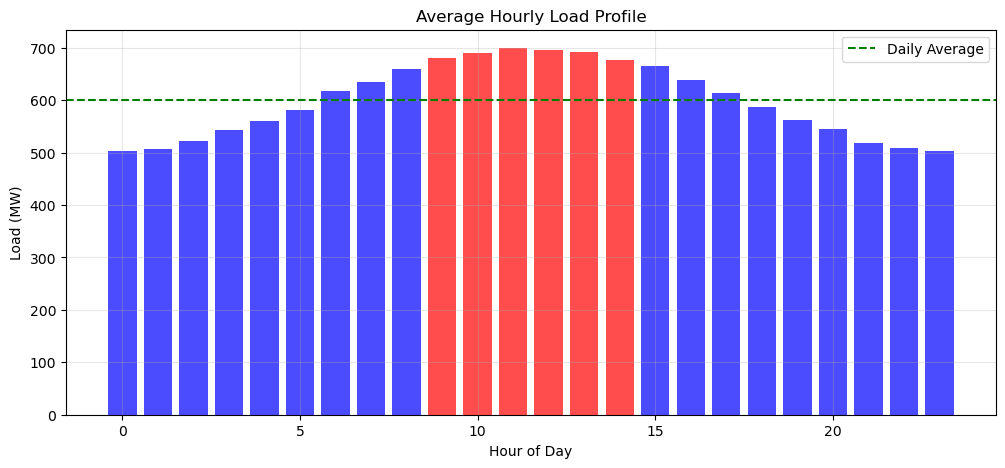

Peak hour: 11:00 (699 MW)
Off-peak hour: 0:00 (503 MW)


In [44]:
# Solution
load_df_copy = load_df.copy()  # Always work on a copy!
load_df_copy['hour'] = load_df_copy.index.hour
hourly_load = load_df_copy.groupby('hour')['system_load'].mean()

# Find peak threshold
threshold = hourly_load.quantile(0.75)
colors = ['red' if load > threshold else 'blue' for load in hourly_load]

# Create visualization
plt.figure(figsize=(12, 5))
plt.bar(range(24), hourly_load.values, color=colors, alpha=0.7)
plt.axhline(load_df_copy['system_load'].mean(), color='green', 
            linestyle='--', label='Daily Average')
plt.xlabel('Hour of Day')
plt.ylabel('Load (MW)')
plt.title('Average Hourly Load Profile')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Peak hour: {hourly_load.idxmax()}:00 ({hourly_load.max():.0f} MW)")
print(f"Off-peak hour: {hourly_load.idxmin()}:00 ({hourly_load.min():.0f} MW)")

## Exercise 2: Price Statistics with Safe Operations

Electricity prices vary significantly throughout the day and respond to system conditions. Calculate the average, minimum, maximum, and standard deviation of prices for each hour. Identify price spikes by finding periods where prices exceed the mean by more than two standard deviations.

Create a summary table showing these statistics for the top 5 most expensive hours. Also calculate what percentage of time prices exceed $45/MWh. Make sure to use proper indexing methods to avoid warnings.

**Hint:** Use describe() on grouped data to get multiple statistics at once. Use `.loc[]` with boolean masks for safe filtering.

In [45]:
# Exercise 2: Your code here

### Solution to Exercise 2

In [46]:
# Solution
price_df_copy = price_df.copy()
price_df_copy['hour'] = price_df_copy.index.hour
hourly_stats = price_df_copy.groupby('hour')['lmp'].describe()

# Find top 5 most expensive hours
top_hours = hourly_stats.nlargest(5, 'mean')
print("Top 5 most expensive hours:")
print(top_hours[['mean', 'min', 'max', 'std']])

# Find price spikes using safe operations
mean_price = price_df_copy['lmp'].mean()
std_price = price_df_copy['lmp'].std()
spike_threshold = mean_price + 2 * std_price

# Use loc for safe boolean indexing
spike_mask = price_df_copy['lmp'] > spike_threshold
spikes = price_df_copy.loc[spike_mask].copy()

print(f"\nPrice spike threshold: ${spike_threshold:.2f}/MWh")
print(f"Number of price spikes: {len(spikes)} ({len(spikes)/len(price_df_copy)*100:.1f}%)")

# Percentage above $45
high_price_pct = (price_df_copy['lmp'] > 45).mean() * 100
print(f"\nTime with prices > $45/MWh: {high_price_pct:.1f}%")

Top 5 most expensive hours:
       mean    min    max   std
hour                           
11    49.82  47.60  51.28  1.09
12    49.10  46.18  53.01  2.22
13    48.43  44.31  52.95  2.71
10    47.39  42.88  51.61  2.43
14    47.17  42.84  49.71  2.03

Price spike threshold: $53.08/MWh
Number of price spikes: 0 (0.0%)

Time with prices > $45/MWh: 30.9%


## Exercise 3: Renewable Integration Analysis with Performance

Renewable energy integration is a key challenge in modern power systems. Calculate the renewable penetration (percentage of total generation from wind and solar) for each time period. Find the maximum renewable penetration achieved and when it occurred.

Create a scatter plot showing the relationship between renewable generation and electricity prices. Add a trend line and calculate the correlation coefficient. Compare the performance of using apply() versus vectorized operations for calculating renewable penetration.

**Hint:** Use vectorized operations for better performance. Remember that `np.where()` is often faster than `apply()` for conditional operations.

In [47]:
# Exercise 3: Your code here

### Solution to Exercise 3

#### Performance Comparison

In [48]:
# Calculate renewable metrics using vectorized operations
system_data_copy = system_data.copy()

# Slow way with apply
start = time.time()
system_data_copy['renewable_gen_slow'] = system_data_copy.apply(
    lambda row: row['wind'] + row['solar'], axis=1
)
time_apply = time.time() - start

# Fast way with vectorization
start = time.time()
system_data_copy['renewable_gen'] = system_data_copy['wind'] + system_data_copy['solar']
time_vector = time.time() - start

print(f"Apply time: {time_apply*1000:.2f} ms")
print(f"Vectorized time: {time_vector*1000:.2f} ms")
print(f"Speedup: {time_apply/time_vector:.1f}x")

Apply time: 1.63 ms
Vectorized time: 0.29 ms
Speedup: 5.6x


#### Renewable Penetration Analysis

In [49]:
# Calculate renewable percentage
system_data_copy['renewable_pct'] = (
    system_data_copy['renewable_gen'] / system_data_copy['total_gen'] * 100
)

# Find maximum penetration
max_renewable = system_data_copy['renewable_pct'].max()
max_time = system_data_copy['renewable_pct'].idxmax()
print(f"Maximum renewable penetration: {max_renewable:.1f}% at {max_time}")

Maximum renewable penetration: 24.2% at 2024-01-01 11:00:00


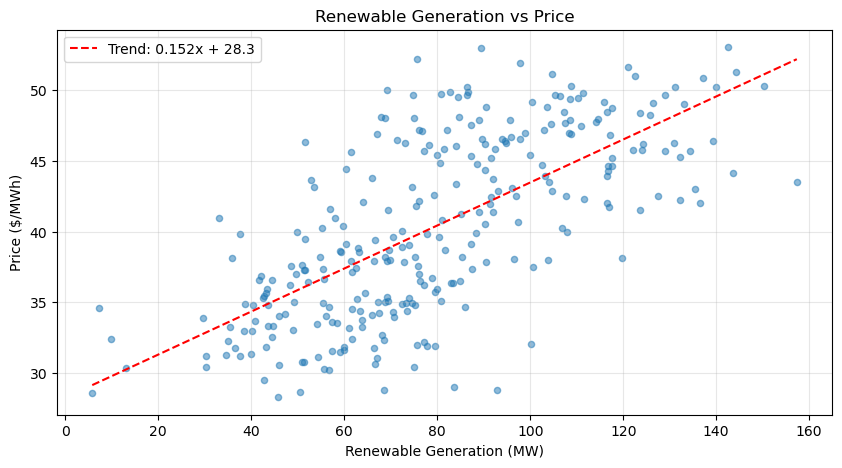


Correlation: 0.684

A negative correlation suggests that higher renewable generation
tends to reduce electricity prices (merit order effect).


In [50]:
# Analyze price relationship
plt.figure(figsize=(10, 5))
plt.scatter(system_data_copy['renewable_gen'], system_data_copy['lmp'], 
            alpha=0.5, s=20)

# Add trend line
z = np.polyfit(system_data_copy['renewable_gen'], system_data_copy['lmp'], 1)
p = np.poly1d(z)
x_line = np.linspace(system_data_copy['renewable_gen'].min(), 
                    system_data_copy['renewable_gen'].max(), 100)
plt.plot(x_line, p(x_line), 'r--', 
         label=f'Trend: {z[0]:.3f}x + {z[1]:.1f}')

plt.xlabel('Renewable Generation (MW)')
plt.ylabel('Price ($/MWh)')
plt.title('Renewable Generation vs Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate correlation
correlation = system_data_copy['renewable_gen'].corr(system_data_copy['lmp'])
print(f"\nCorrelation: {correlation:.3f}")
print("\nA negative correlation suggests that higher renewable generation")
print("tends to reduce electricity prices (merit order effect).")

## Summary

You've now mastered the essential Pandas operations for power system data analysis, including critical concepts often overlooked in basic tutorials. You understand the difference between loc and iloc, know how to avoid the SettingWithCopyWarning, and can optimize performance through vectorization.

The key skills you've developed include proper DataFrame indexing, safe data cleaning practices, efficient time-series operations, and performance-optimized aggregations. Most importantly, you've learned to avoid the common pitfalls that can lead to incorrect results or poor performance.

As you work with real power system data, remember these critical points: always use `.copy()` when you need independent data, prefer vectorized operations over loops, use `.loc[]` for safe value assignment, and check for duplicates before merging. With these skills and awareness of common pitfalls, you're prepared to handle complex power system data analysis tasks efficiently and correctly.

```{admonition} Final Best Practices Checklist
:class: tip

- Use `.copy()` when creating subsets you'll modify
- Use `.loc[]` for label-based selection and assignment
- Use `.iloc[]` for position-based selection
- Vectorize operations instead of using loops
- Check for duplicates before merging
- Set appropriate data types to save memory
- Handle missing values explicitly
- Be aware of timezone issues in time series

```

In [52]:
# Clean up
import os
if os.path.exists('generation.csv'):
    os.remove('generation.csv')
print("Cleanup complete")

Cleanup complete
